# Main Dataframe - creating additional features
* read in pickle
* look at adding common stop word counts some may be more common than others for some translators
* look at adding the most common adverbs, adjectives etc. for each translator

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import textacy
import re
import nltk
import gensim

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# NLP Using a count vectorizer.
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction import DictVectorizer

from collections import Counter

import pickle
import os

plt.style.use('ggplot')

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v01.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

## Try some bag of word analysis
We can potentially generate more features by examining a bag of words analysis

### Try first on chunks without dropping stop words

In [4]:
def cvec_to_df(column, stopwords=False, stoplist=None):
    """Generate a bag of words dataframe from a column of texts"""
    #  set vectorizer
    if stopwords:
        cvec = CountVectorizer(stop_words=stoplist)
    else:
        cvec = CountVectorizer()
    # Fit our vectorizer 
    cvec.fit(column)
    # Transform data
    cvec_mat = cvec.transform(column)
    return pd.DataFrame(cvec_mat.toarray(), columns=cvec.get_feature_names())

In [5]:
df_bow_nostop = cvec_to_df(df['chunks'])

### Count number of words in total per translator for normalisation

In [6]:
# count the total number of words per translator to allow us to normalise the counts of each individual word
trans_word_counts = df_bow_nostop.join(df['trans_code']).groupby('trans_code').sum().sum(axis=1)
trans_word_counts

trans_code
0    298708
1    364380
2    241372
dtype: int64

In [7]:
# add translator code column and groupby it
# add counts for each word
sub_df = df_bow_nostop.join(df['trans_code']).groupby('trans_code').sum().sort_values(by=0, ascending=False, axis=1)

In [8]:
for t in df['trans_code'].unique():
    print(t)

0
2
1


In [9]:
df['trans_code'].nunique()

3

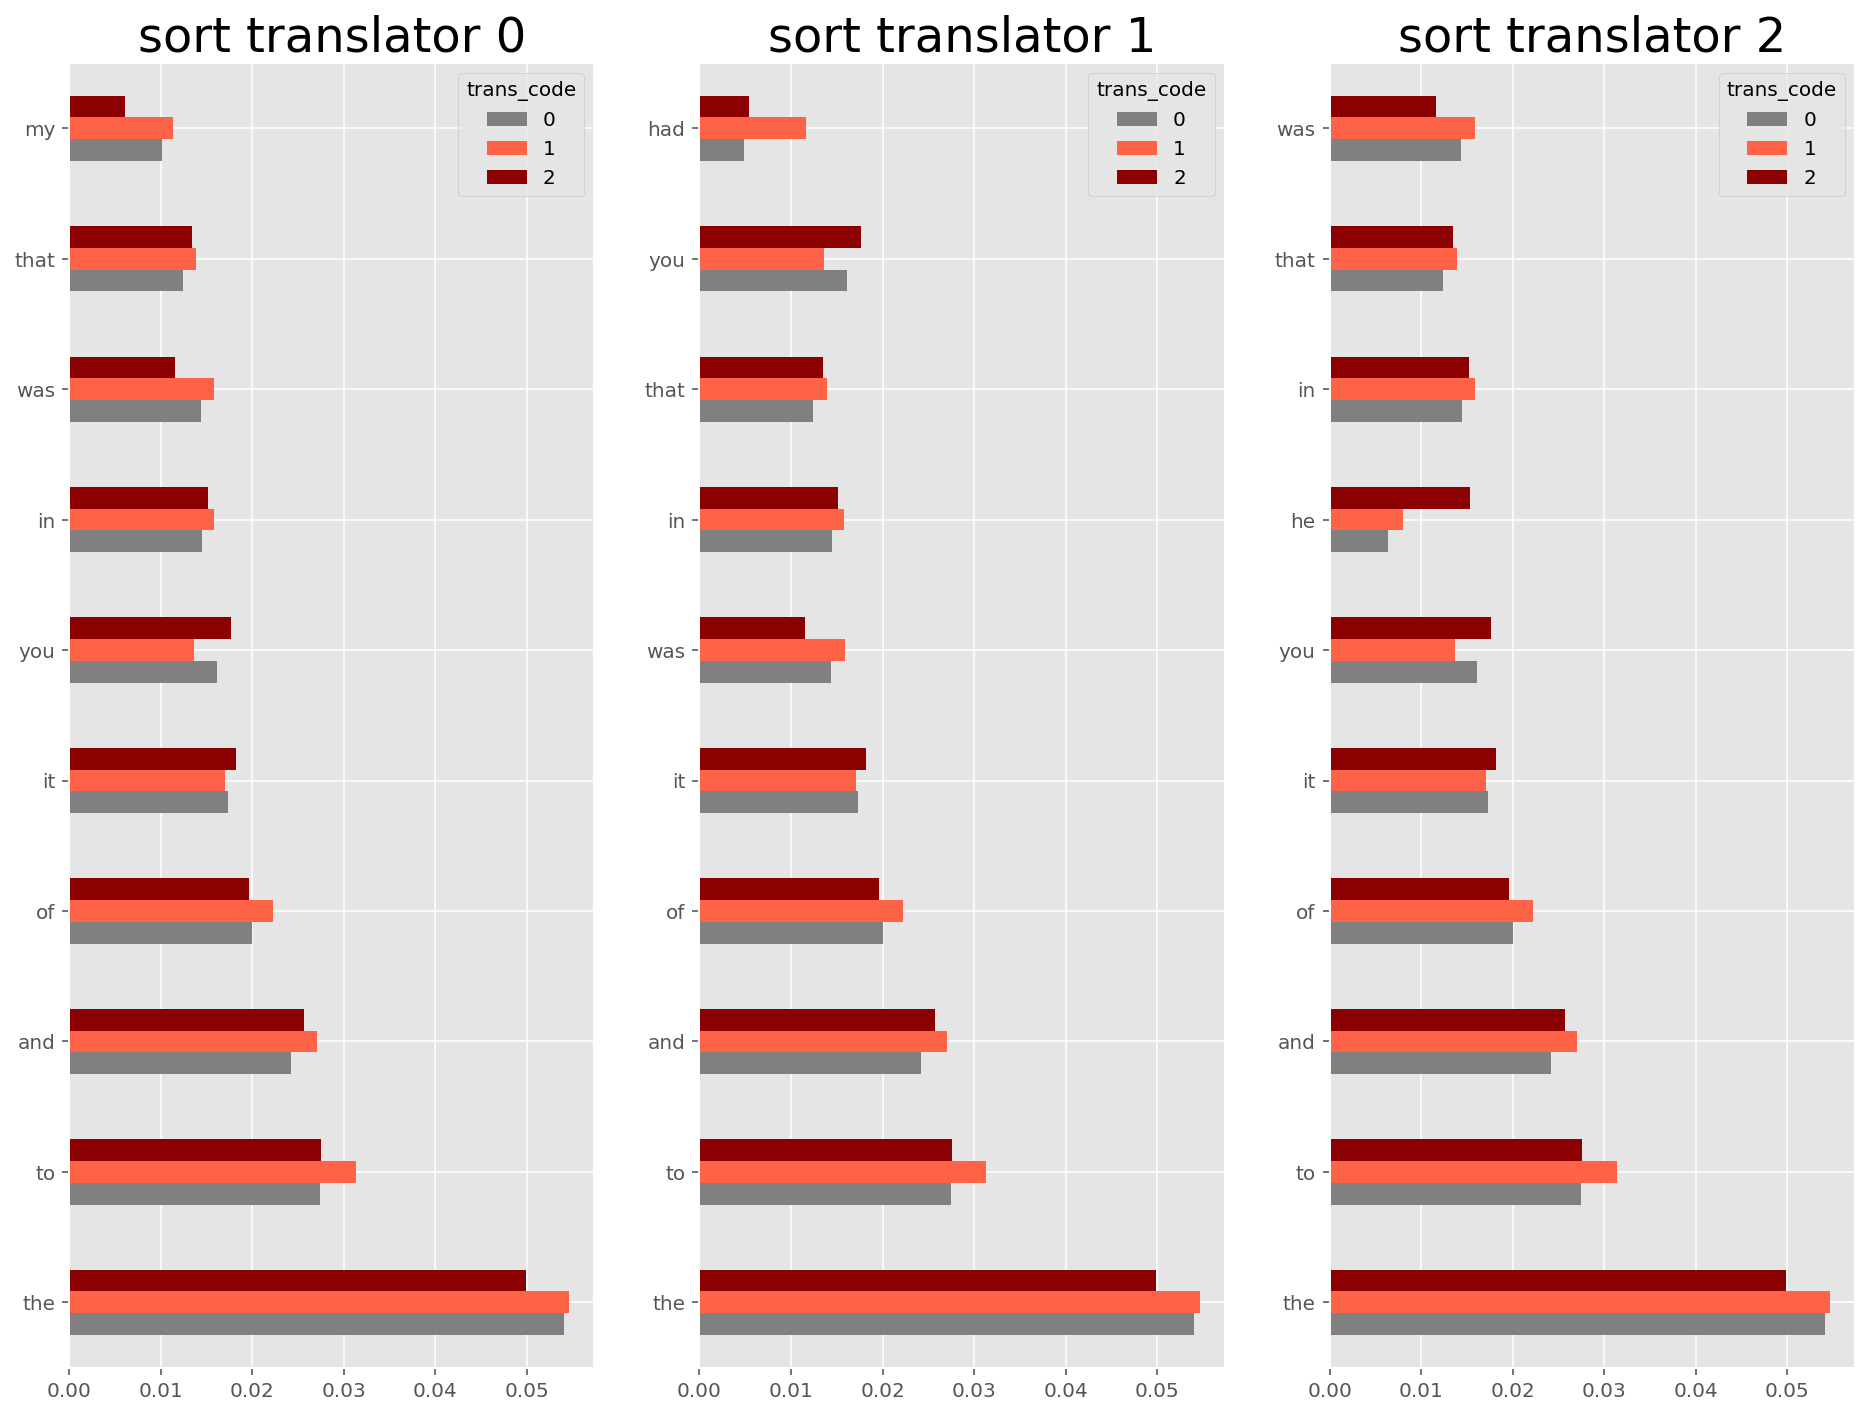

In [10]:
# add translator code column and groupby it
# add counts for each word
# sort by count for each translator 
# divide by the total word counts per translator
# plot sorted by most common word for each translator
sns.set_palette(['gray', 'tomato', 'darkred'])
fig, ax = plt.subplots(ncols=df['trans_code'].nunique(), figsize=(16, 12))
for t in df['trans_code'].unique():
    df_bow_ns_counts = df_bow_nostop.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=t, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0)
#     df_bow_ns_counts.iloc[:,:20].T.plot(kind='barh', ax=ax[t], colormap='Set1')
    df_bow_ns_counts.iloc[:,:10].T.plot(kind='barh', ax=ax[t])

    ax[t].set_title('sort translator ' + str(t), fontsize=24)
    
plt.savefig('../../../../Documents/murakami/plots/all_words_sort_trans.png')
plt.show()

In [11]:
# select some common words for each translator to add to predictors
# choose some which have rate of use differences
df_bow_nostop[['the', 'to', 'and', 'of', 'you', 'was', 'he', 'she', 'had']].head()

,the,to,and,of,you,was,he,she,had
0,10,3,6,9,1,1,1,2,1
1,7,0,4,4,0,8,2,3,0
2,14,2,5,7,0,5,0,4,0
3,11,4,2,6,2,4,0,5,1
4,12,2,5,4,3,5,0,4,2


### Now try on chunks dropping stop words

In [12]:
df_bow_stop = cvec_to_df(df['chunks'], stopwords=True, stoplist='english')

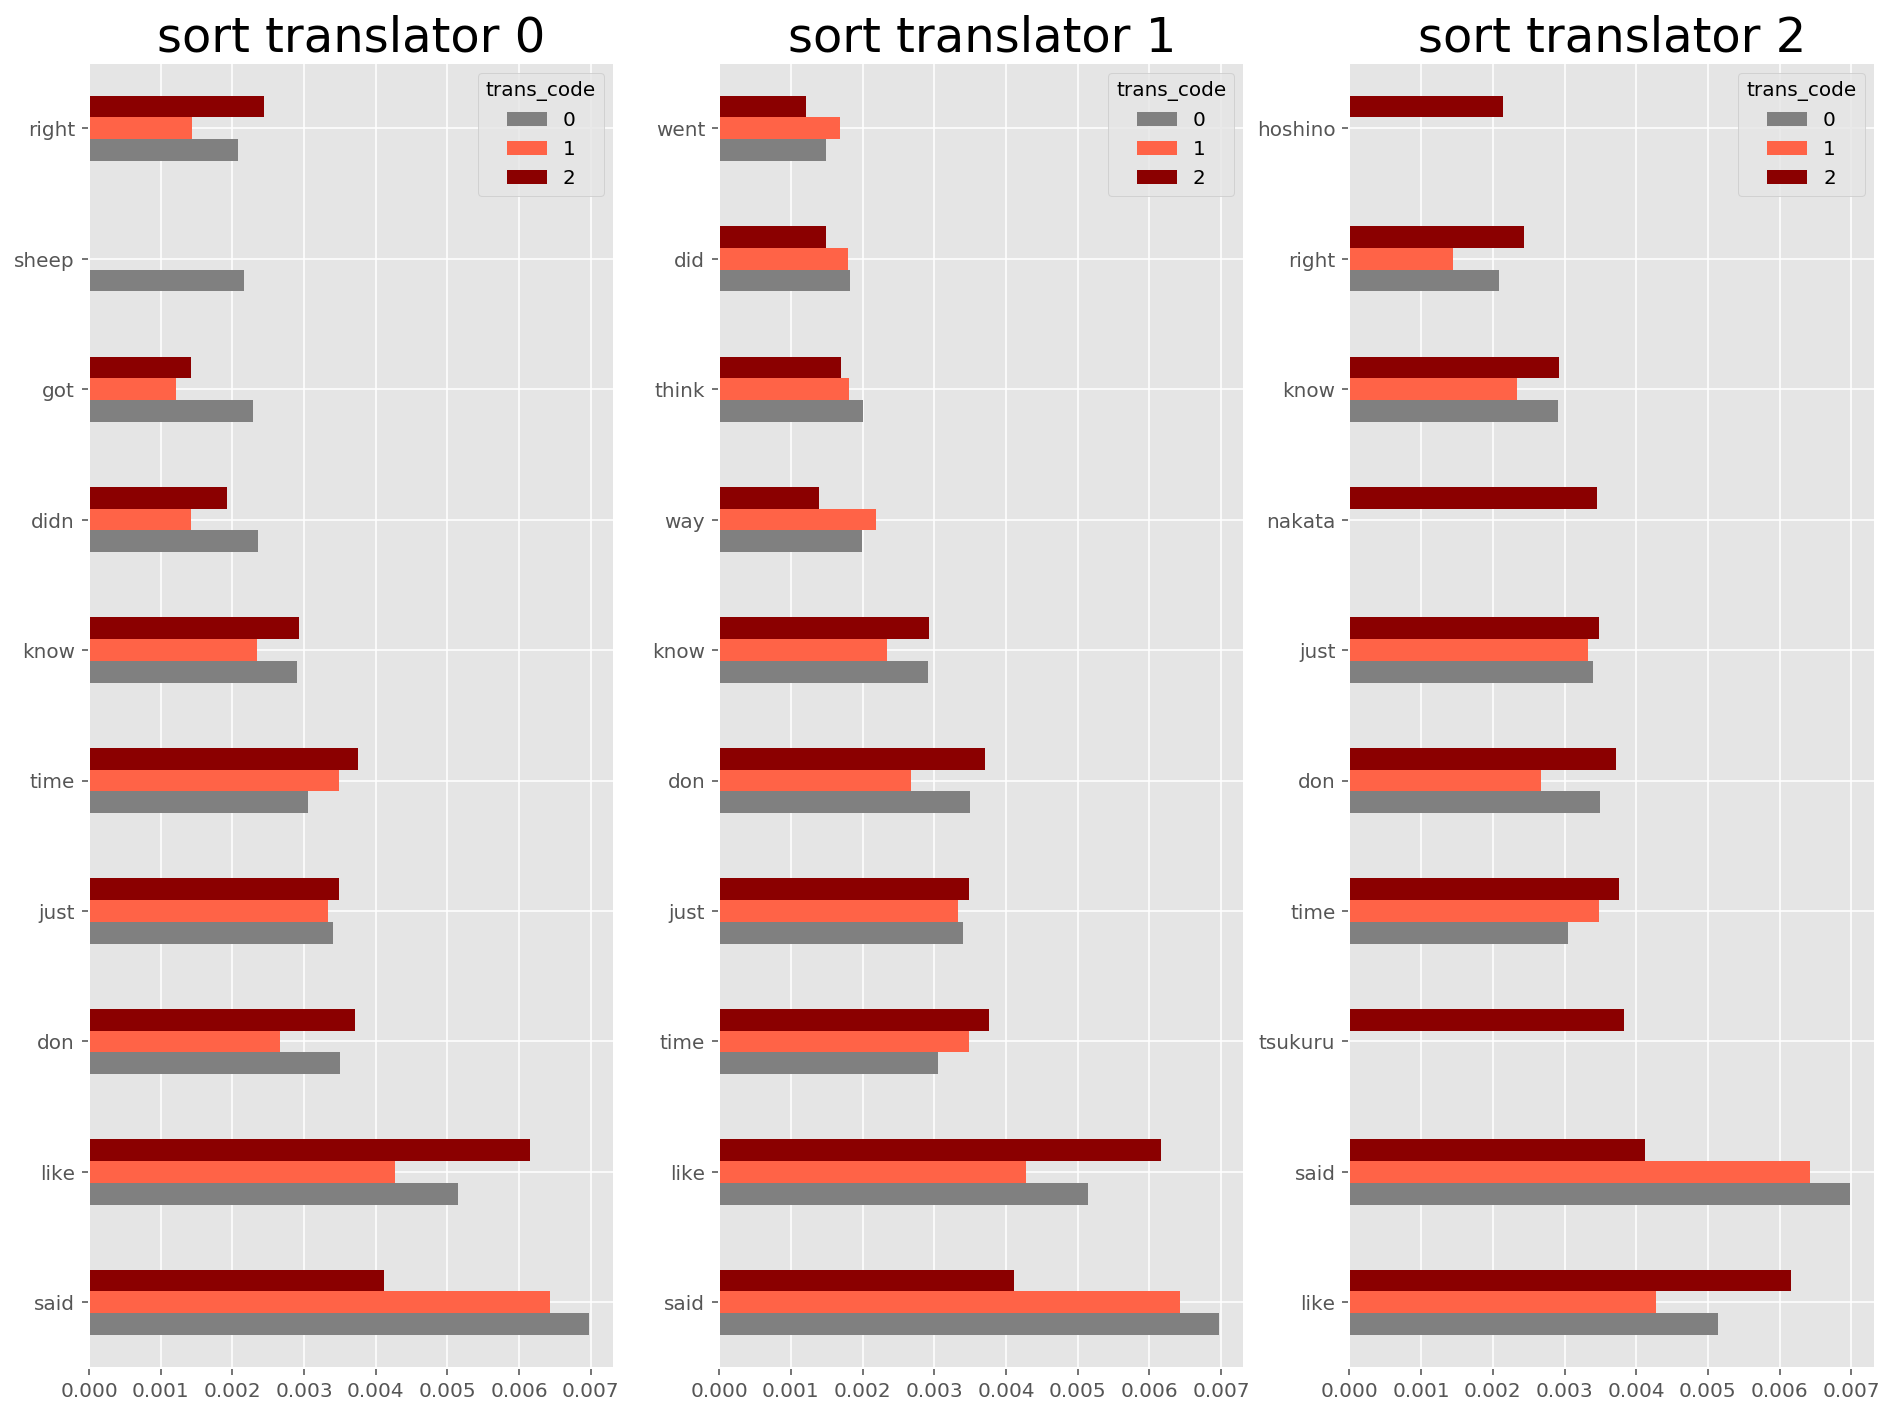

In [13]:
# add translator code column and groupby it
# add counts for each word
# sort by count for each translator 
# divide by the total word counts per translator
# plot sorted by most common word for each translator
sns.set_palette(['gray', 'tomato', 'darkred'])
fig, ax = plt.subplots(ncols=df['trans_code'].nunique(), figsize=(16, 12))
for t in df['trans_code'].unique():
    df_bow_s_counts = df_bow_stop.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=t, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0)
    df_bow_s_counts.iloc[:,:10].T.plot(kind='barh', ax=ax[t])
    ax[t].set_title('sort translator ' + str(t), fontsize=24)
    
    
plt.savefig('../../../../Documents/murakami/plots/stop_words_sort_trans.png')
plt.show()

### Take aways
* without removing stopwords (the, to and, of, it etc.) are very common - can try a count of about 10 of these per chunk
* said, like, just, time, know and a few other words are quite common - can try counts of these as well
* need to look at the names in the text quite common - can perhaps look at count of types of word like name - may already be there
* could think about adding some common nouns, verbs, adjectives  etc which are not related to the story - may need to be careful here


In [14]:
#  select some common stop words for each translator to add to predictors
df_bow_stop[['said', 'like', 'just', 'time', 'know', 'think', 'got', 'right']].head(3)

,said,like,just,time,know,think,got,right
0,1,2,0,0,0,0,2,0
1,0,0,0,1,0,0,1,0
2,0,1,0,3,0,0,0,0


In [15]:
words_to_add = ['the', 'to', 'and', 'of', 'you', 'was', 'he', 'she', 'had',
                'said', 'like', 'just', 'time', 'know', 'think', 'got', 'right']
df = df.join(df_bow_nostop[words_to_add])

In [16]:
df.shape

(5253, 85)

In [17]:
# rename these new columns by adding suffix w for word to be able to select them later
df.columns = [str(col) + '_w' if col in words_to_add else str(col) for col in df.columns]

In [18]:
predictor_cols2 = ['n_sents_norm',
 'n_words_norm',
 'n_chars_norm',
 'n_syllables_norm',
 'n_unique_words_norm',
 'n_long_words_norm',
 'n_monosyllable_words_norm',
 'n_polysyllable_words_norm',
 'pron_count_norm',
 'verb_count_norm',
 'det_count_norm',
 'adj_count_norm',
 'noun_count_norm',
 'adp_count_norm',
 'cconj_count_norm',
 'sconj_count_norm',
 'adv_count_norm',
 'aux_count_norm',
 'part_count_norm',
 'propn_count_norm',
 'intj_count_norm']

In [19]:
predictor_cols3 = predictor_cols2 + [col for col in df.columns if col.endswith('_w')]

In [20]:
predictor_cols3

['n_sents_norm',
 'n_words_norm',
 'n_chars_norm',
 'n_syllables_norm',
 'n_unique_words_norm',
 'n_long_words_norm',
 'n_monosyllable_words_norm',
 'n_polysyllable_words_norm',
 'pron_count_norm',
 'verb_count_norm',
 'det_count_norm',
 'adj_count_norm',
 'noun_count_norm',
 'adp_count_norm',
 'cconj_count_norm',
 'sconj_count_norm',
 'adv_count_norm',
 'aux_count_norm',
 'part_count_norm',
 'propn_count_norm',
 'intj_count_norm',
 'the_w',
 'to_w',
 'and_w',
 'of_w',
 'you_w',
 'was_w',
 'he_w',
 'she_w',
 'had_w',
 'said_w',
 'like_w',
 'just_w',
 'time_w',
 'know_w',
 'think_w',
 'got_w',
 'right_w']

In [21]:
X = df[predictor_cols3]
y = df['trans_code']

In [22]:
indices = list(df.index)

In [23]:
# stratify based on your target variable
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=1)

In [24]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [25]:
# set up a logistic regression model
lr_02 = LogisticRegression(max_iter=1000)
cross_val_score(lr_02, X_train, y_train, cv=5).mean()

0.6542157861955722

In [26]:
lr_02.fit(X_train, y_train)
predictions = lr_02.predict(X_test)
lr_02.score(X_test, y_test)

0.6584205518553758

In [27]:
conmat = confusion_matrix(
    y_test, predictions, labels=[0, 1, 2])

confusion = pd.DataFrame(conmat, index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                         columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel'])
confusion

,predicted birnbaum,predicted rubin,predicted gabriel
actual birnbaum,234,74,44
actual rubin,67,290,61
actual gabriel,62,51,168


### Add some common adverbs and adjectives

In [28]:
def adj_list(item):
    x = [(token.pos_ , token.lemma_) for token in item]
    return [list(y)[1] for y in x if list(y)[0] == 'ADJ']

def adv_list(item):
    x = [(token.pos_ , token.lemma_) for token in item]
    return [list(y)[1] for y in x if list(y)[0] == 'ADV']

df['adj_list'] = df['parsed'].map(adj_list)
df['adv_list'] = df['parsed'].map(adv_list)

In [29]:
# df.head()

In [30]:
def list_to_str(item):
    return " ".join(item)

df['adj_str'] = df['adj_list'].map(list_to_str)
df['adv_str'] = df['adv_list'].map(list_to_str)

In [31]:
# df.head()

In [32]:
df_adj = cvec_to_df(df['adj_str'])
df_adv = cvec_to_df(df['adv_str'])

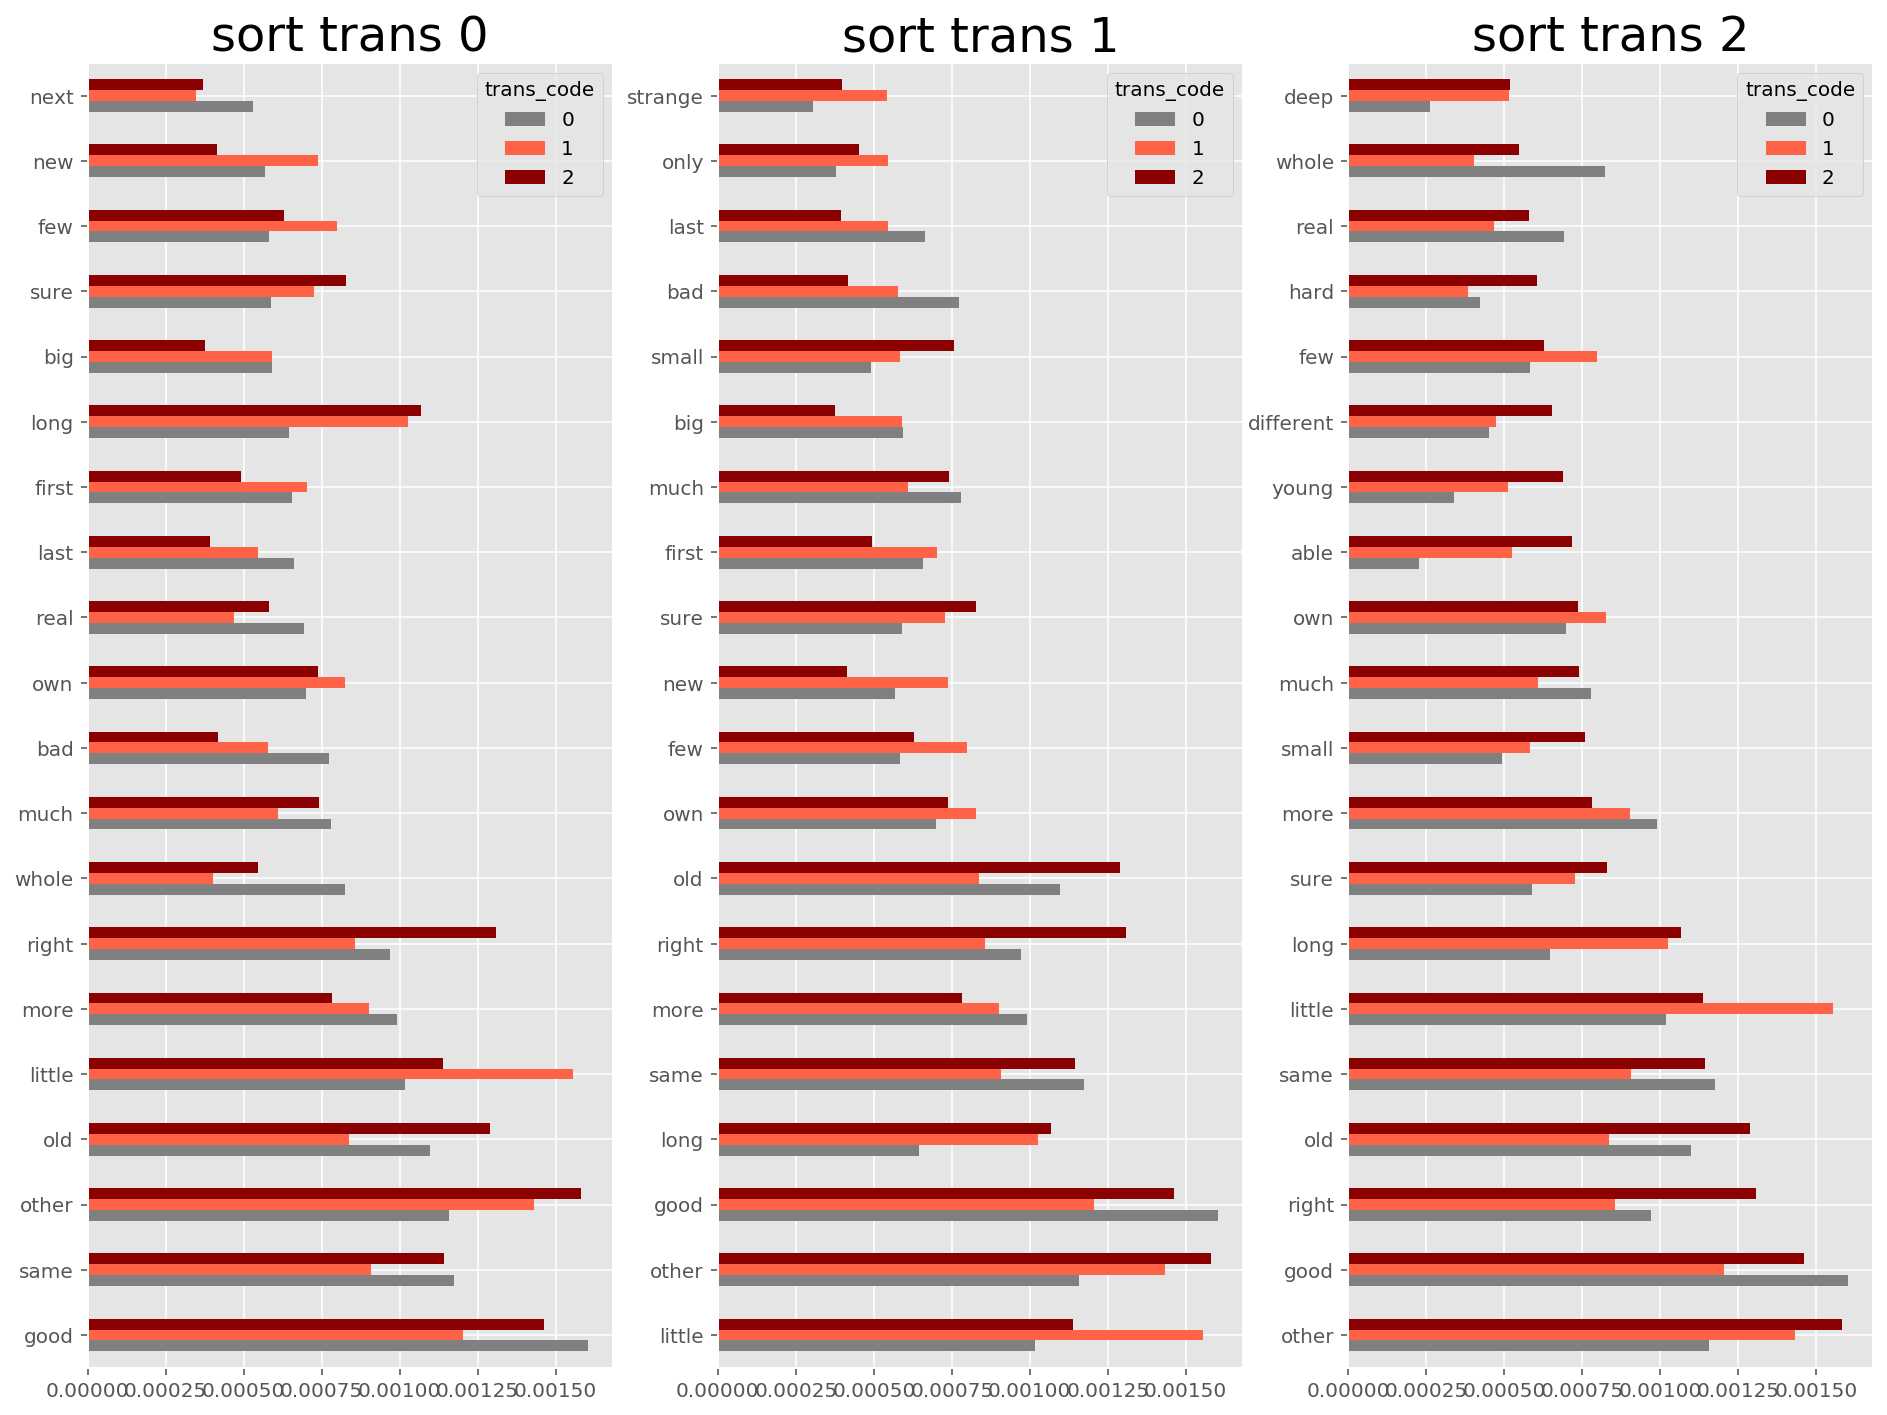

In [33]:
# add translator code column and groupby it
# add counts for each word
# sort by count for each translator 
# divide by the total word counts per translator
# plot sorted by most common word for each translator

fig, ax = plt.subplots(ncols=df['trans_code'].nunique(), figsize=(16, 12))
for t in df['trans_code'].unique():
    df_adj_counts = df_adj.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=t, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0)
    df_adj_counts.iloc[:,:20].T.plot(kind='barh', ax=ax[t])
    ax[t].set_title('sort trans ' + str(t), fontsize=24)

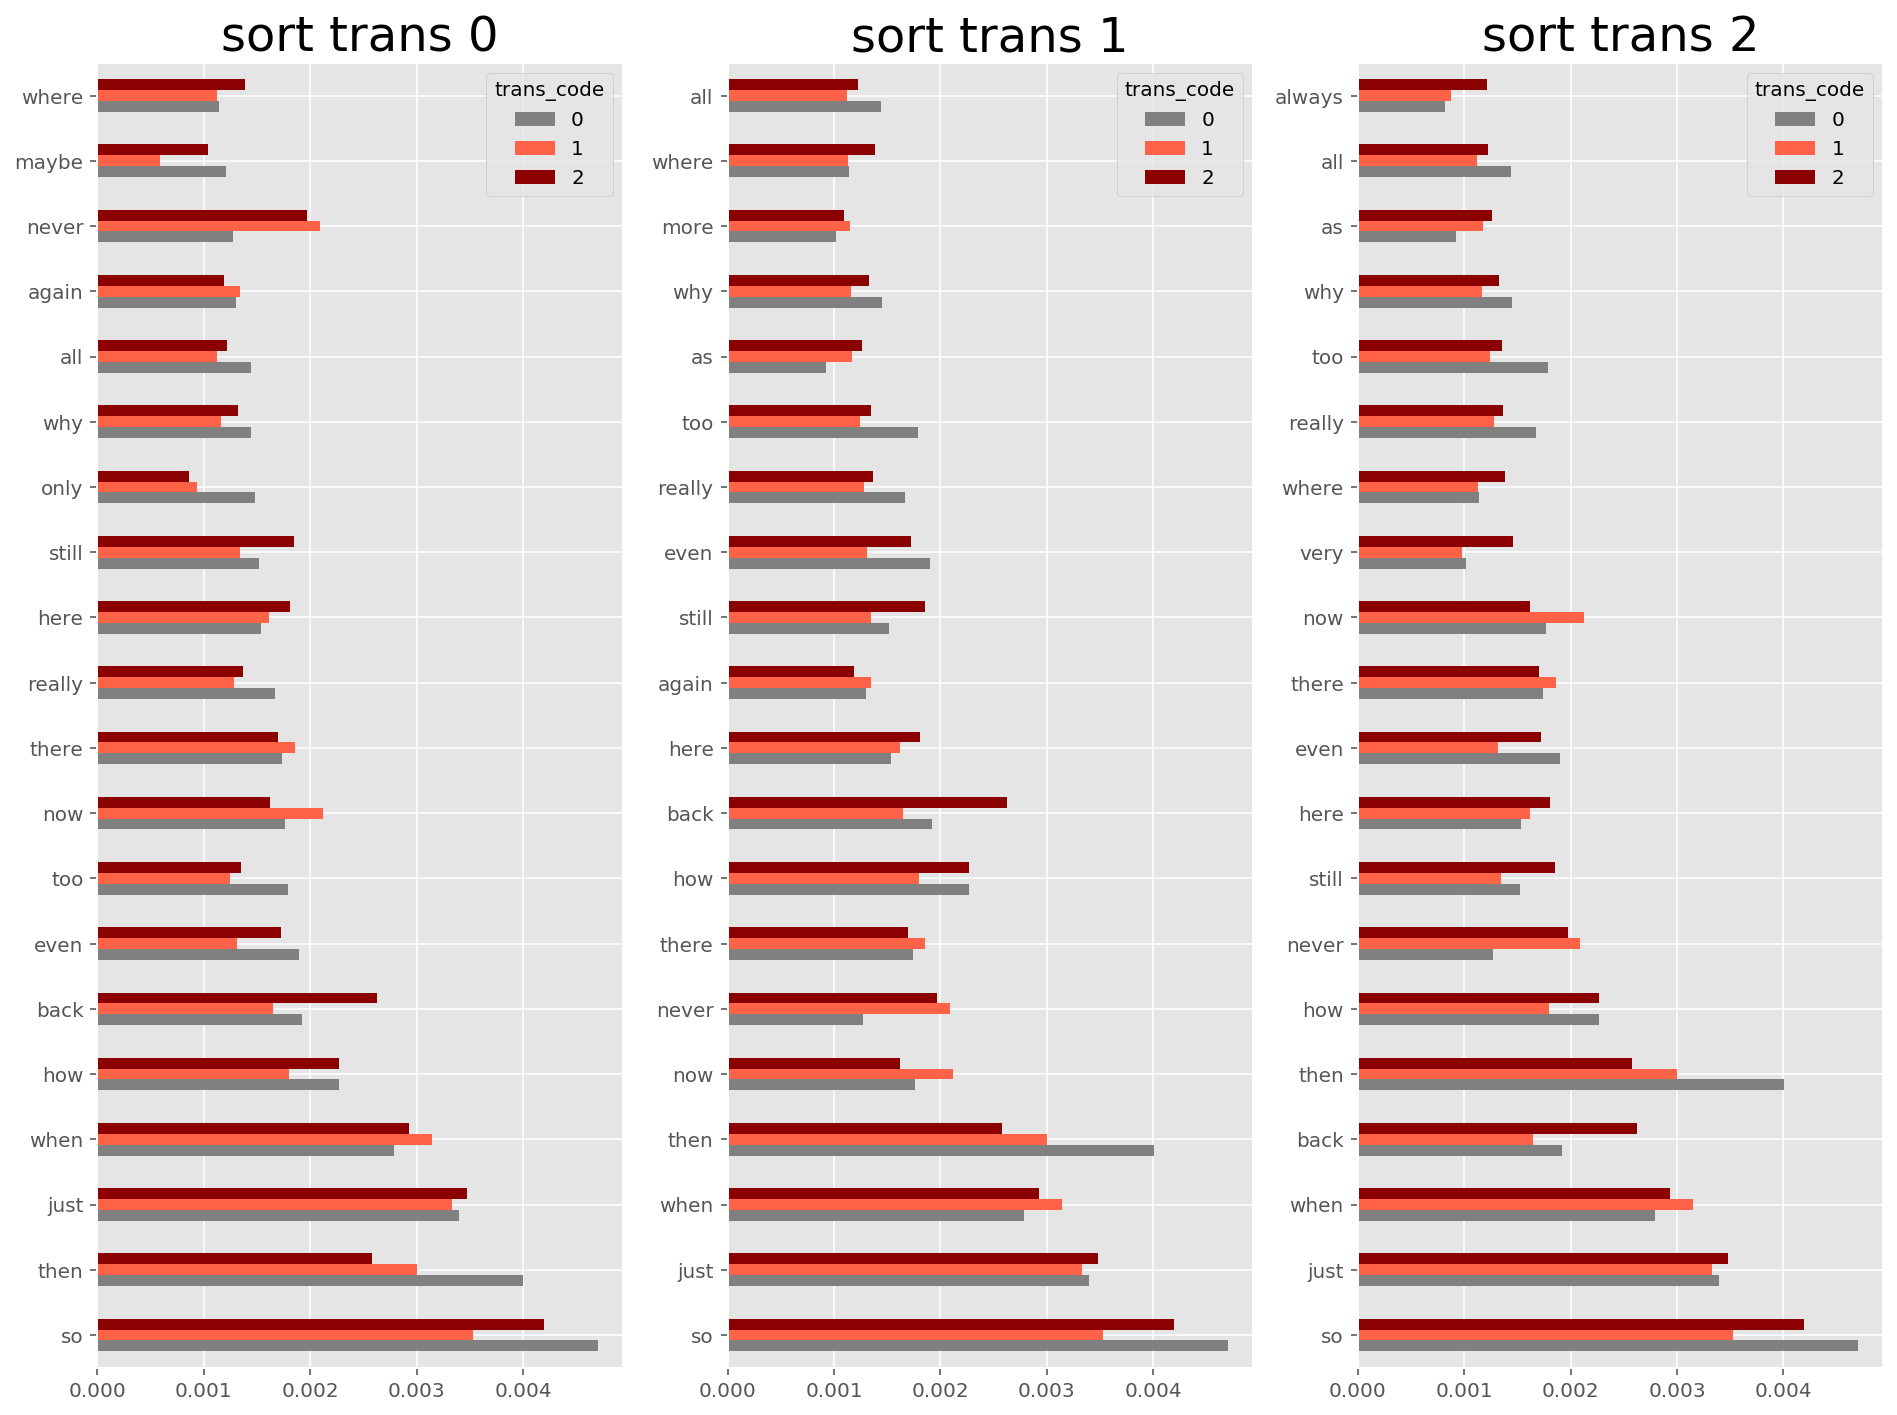

In [34]:
# add translator code column and groupby it
# add counts for each word
# sort by count for each translator 
# divide by the total word counts per translator
# plot sorted by most common word for each translator

fig, ax = plt.subplots(ncols=df['trans_code'].nunique(), figsize=(16, 12))
for t in df['trans_code'].unique():
    df_adv_counts = df_adv.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=t, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0)
    df_adv_counts.iloc[:,:20].T.plot(kind='barh', ax=ax[t])
    ax[t].set_title('sort trans ' + str(t), fontsize=24)

In [35]:
top_adj_0 = df_adj.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=0, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0).iloc[:,:20].columns
top_adj_1 = df_adj.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=1, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0).iloc[:,:20].columns
top_adj_2 = df_adj.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=2, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0).iloc[:,:20].columns

In [36]:
top_adv_0 = df_adv.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=0, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0).iloc[:,:20].columns
top_adv_1 = df_adv.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=1, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0).iloc[:,:20].columns
top_adv_2 = df_adv.join(df['trans_code']).groupby('trans_code').sum() \
                        .sort_values(by=2, ascending=False, axis=1) \
                        .div(trans_word_counts, axis=0).iloc[:,:20].columns

In [37]:
all_top_adj = list(set(top_adj_0) | set(top_adj_1) | set(top_adj_2))

In [38]:
all_top_adv = list(set(top_adv_0) | set(top_adv_1) | set(top_adv_2))

In [39]:
adj_to_add = [x for x in all_top_adj if x not in df.columns]

In [40]:
adv_to_add = [x for x in all_top_adv if x not in df.columns]

In [41]:
adv_to_add

['really',
 'back',
 'always',
 'then',
 'more',
 'even',
 'why',
 'maybe',
 'again',
 'now',
 'just',
 'how',
 'where',
 'very',
 'only',
 'there',
 'still',
 'so',
 'too',
 'when',
 'all',
 'here',
 'never',
 'as']

In [42]:
adj_to_add

['new',
 'other',
 'more',
 'small',
 'deep',
 'whole',
 'first',
 'bad',
 'little',
 'next',
 'much',
 'own',
 'hard',
 'last',
 'only',
 'big',
 'right',
 'long',
 'old',
 'strange',
 'same',
 'young',
 'sure',
 'able',
 'real',
 'different',
 'good',
 'few']

In [43]:
df = df.join(df_adv[adv_to_add])

In [44]:
# rename these new columns by adding suffix w for word to be able to select them later
df.columns = [str(col) + '_adv' if col in adv_to_add else str(col) for col in df.columns]

In [45]:
df = df.join(df_adj[adj_to_add])

In [46]:
# rename these new columns by adding suffix w for word to be able to select them later
df.columns = [str(col) + '_adj' if col in adj_to_add else str(col) for col in df.columns]

In [47]:
df.head(2)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,always_adv,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.593220,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",I got off near the end of the line. The map p...,Alfred Birnbaum,A Wild Sheep Chase,"( , I, got, off, near, the, end, of, the, line...",15,176,734,229,118,29,132,9,0,935,16.042781,188.235294,785.026738,244.919786,126.203209,31.016043,141.176471,9.625668,-0.7902,0.079,0.891,0.030,17.0,22.0,25.0,13.0,5.0,29.0,42.0,22.0,5.0,2.0,12.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0


## A problem with the book 'A Wild Sheep Chase'
### Handling Unusual Text
* While checking some chunks of text we note that there are some unusual joined up words in 2 of the books, namely 'A Wild Sheep Chase' and 'Dance Dance Dance'
* When the original text in the ebooks are checked we see that this is not a formatting error but rather an unusual characteristic of the dialogue with a character known as the 'Sheep Man'
* It is unlikely much can be learnt about the translation styles of the translators from these passages and so we aim to remove them from the dataset
* By counting the number of words with more than 15 characters we can find passages with this style of dialogue by assuming that there are 3 or more of this type of word. 

In [48]:
strange_chunk = df[(df.book_title == 'A Wild Sheep Chase') &  (df.book_chunk_no == 420)]
strange_chunk.chunks.iloc[0]

' “Youwon’ttellanyone?” “I won’t tell anyone.” “Ididn’twanttogoofftowar.” For the next few minutes, we walked on without a word between us. “War with whom?” I asked. “Dunno,” coughed out the Sheep Man. “ButIdidn’twanttogo. Anyway that’swhyI’masheep.Asheepwhostayswherehebelongsuphere.” “You from Junitaki-cho?” “Uhhuhbutdon’ttellanyone.” “I won’t,” I said. “You don’t like the town?” “Thetowndownthere?” “Yeah.” “Don’tlikeitatall.Toofullofsoldiers,” the Sheep Man coughed again. “Whereyoufrom?” “Tokyo.” “Heardaboutthewar?” “Nope.” At that the Sheep Man seemed to lose all interest in me. He remained silent until we reached the entrance to the pasture. “Care to stop by the house?” I asked the Sheep Man. “Gottalayinwintersupplies,” he said. “Realbusy.Maybenexttime.” “I’d like to see my friend,” I said. “I’ve got something I have to see him about next week.” The Sheep Man shook his head forlornly. His ears flapped. “SorrybutlikeIsaidbeforeit’snotuptous.'

In [49]:
# create attribute with count of very long words per chunk
df['vlong_words_count'] = df['chunks'].apply(lambda x: len([word for word in x.split(' ') if len(word) > 15]))

In [50]:
# confirm how many chunks of text are affected
len(df[df.vlong_words_count >= 3])

41

In [51]:
df = df[df.vlong_words_count < 3]

In [52]:
out_path = '../../../../Documents/murakami/pkl3/'
out_name = 'df_all_v02'
out_full_path = out_path + out_name + '.pkl'

In [53]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(df, fp)


# read back pickle
with open (out_full_path, 'rb') as fp:
    df_read = pickle.load(fp)